In [1]:
!pip install torch-geometric -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 23.0 MB/s eta 0:00:00


## Imports

In [2]:
import numpy as np
import torch
from torch_geometric.nn import SAGEConv
from torch_geometric.data import Data
import networkx as nx
from torch_geometric.utils import from_networkx
import matplotlib.pyplot as plt
from tqdm import tqdm

## Graph Robustness Metrics

**1. Effective Graph Resistance (EGR)**  
   $$
   R_g = \frac{2}{N-1} \sum_{i=1}^{N-c} \frac{1}{\lambda_i}
   $$
   where $ \lambda_i $ are the eigenvalues of the Laplacian matrix of the graph.

In [3]:
def compute_effective_resistance(graph):
    laplacian = nx.laplacian_matrix(graph).toarray()
    eigenvalues = np.linalg.eigvalsh(laplacian)
    eigenvalues = eigenvalues[eigenvalues > 1e-8]  # Avoid zero eigenvalues
    N = graph.number_of_nodes()
    return (2 / (N - 1)) * np.sum(1 / eigenvalues)

**2. Weighted Spectrum (WS)**  
   $$
   W_s = \sum_i (1 - \lambda_i)^n
   $$
   where $ n $ controls the depth of analysis

In [4]:
def compute_weighted_spectrum(graph, n=4):
    laplacian = nx.normalized_laplacian_matrix(graph).toarray()
    eigenvalues = np.linalg.eigvalsh(laplacian)
    return np.sum((1 - eigenvalues) ** n)

## Algorithm 1: ILGR Embedding Module
**Input:** Graph $ G $, input node features $ X_v $ $ \forall v \in V $, unknown model weights $ W $ (combination weights) and $ Q $ (aggregation weights).

**Output:** Nodes embedding vector $ z_v $ $ \forall v \in V $.

**1. Initialize**: $ h^0_v = X_v $ for all $ v \in V $.
**2. For each layer** $ l = 1 $ to $ L $ do:
   - For each node $ v = 1 $ to $ V $:
     1. Compute neighborhood embedding using attention mechanism:
        $$
        h^l_{N(v)} = \text{Attention}(Q^l h^{l-1}_k) \quad \forall k \in N(v)
        $$
     2. Compute new embedding for node $ v $ using a **skip connection**:
        $$
        h^l_v = \text{ReLU} \left( W^l \left[ h^{l-1}_v || h^{l-2}_v || h^l_{N(v)} \right] \right)
        $$
**3. Return**: Final embedding vector $ z_v = h^L_v $ for all $ v \in V $.


In [5]:
class ILGRNodeEmbedding(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.conv1 = SAGEConv(3, hidden_channels)  # 3 input features: degree, avg_neighbor_degree, criticality
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.conv3 = SAGEConv(hidden_channels, hidden_channels)
        self.attention = torch.nn.MultiheadAttention(hidden_channels, 1)
        
    def forward(self, x, edge_index):
        # Skip connections and attention
        h1 = torch.relu(self.conv1(x, edge_index))
        h2 = torch.relu(self.conv2(h1, edge_index))
        h3 = torch.relu(self.conv3(h2, edge_index))
        h, _ = self.attention(h3, h3, h3)
        return torch.cat([h1, h2, h3, h], dim=-1)

## Regression Module

The regression module applies a **non-linear transformation** using multiple layers:

$$
y_m = f(W_m \cdot y_{m-1} + b_m)
$$

where:
- $ y_m $ is the output of the $ m^{th} $ layer.
- $ W_m $ and $ b_m $ are the **weights** and **biases** of the $ m^{th} $ layer.
- $ f $ is an **activation function**
- The input to the first layer is the **node embedding**:



In [6]:
class RegressionModule(torch.nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc1 = torch.nn.Linear(input_dim, 64)
        self.fc2 = torch.nn.Linear(64, 32)
        self.fc3 = torch.nn.Linear(32, 1)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

## Full Model

In [7]:
class ILGR(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.embedding = ILGRNodeEmbedding(hidden_channels)
        self.regression = RegressionModule(hidden_channels * 4)  # Concatenated embeddings
        
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        embedding = self.embedding(x, edge_index)
        return self.regression(embedding)

### Criticality Score Calculation

### Algorithm 3: Conventional Approach for Identifying Critical Nodes/Links
**Input:** Graph $ G $ with $ V $ nodes.
**Output:** Node critical scores.

**1. For each node/link** $ n $ in $ V $:
   - Remove node $ n $ from the graph $ G $.
   - Compute robustness metric of the **residual graph** $ (G - n) $.
   - Assign a **criticality score** to node $ n $.

**2. End loop**.

3. Rank nodes based on computed **criticality scores**.
4. Top ranks correspond to the **most critical nodes**.
**5. Return**: Top $ N\% $ of most critical nodes.

In [8]:
def compute_criticality_scores(graph, metric):
    scores = []
    for node in tqdm(graph.nodes(), desc="Computing Criticality Scores"):
        subgraph = graph.copy()
        subgraph.remove_node(node)
        score = metric(graph) - metric(subgraph)  # Drop in robustness
        scores.append(score)
    return scores

### Ranking Loss
$$
     L_{ij} = -f(r_{ij}) \log(σ(\hat{y}_{ij})) - (1 - f(r_{ij})) \log(1 - σ(\hat{y}_{ij}))
     $$

In [9]:
"""def pairwise_ranking_loss(y_pred, y_true):
    # Compare all pairs of nodes
    loss = 0
    for i in range(len(y_true)):
        for j in range(i+1, len(y_true)):
            if y_true[i] > y_true[j]:
                loss += torch.log(1 + torch.exp(-(y_pred[i] - y_pred[j])))
            elif y_true[i] < y_true[j]:
                loss += torch.log(1 + torch.exp(y_pred[i] - y_pred[j]))
    return loss / (len(y_true) * (len(y_true)-1) / 2)"""

'def pairwise_ranking_loss(y_pred, y_true):\n    # Compare all pairs of nodes\n    loss = 0\n    for i in range(len(y_true)):\n        for j in range(i+1, len(y_true)):\n            if y_true[i] > y_true[j]:\n                loss += torch.log(1 + torch.exp(-(y_pred[i] - y_pred[j])))\n            elif y_true[i] < y_true[j]:\n                loss += torch.log(1 + torch.exp(y_pred[i] - y_pred[j]))\n    return loss / (len(y_true) * (len(y_true)-1) / 2)'

### Optimize Pairwise Loss Computation
Replace the nested-loop pairwise loss with a vectorized implementation to handle large graphs:

In [10]:
def pairwise_ranking_loss(y_pred, y_true):
    y_pred = y_pred.squeeze()
    y_true = y_true.squeeze()
    
    # Compute all pairwise differences
    diff_pred = y_pred.unsqueeze(1) - y_pred.unsqueeze(0)  # Shape [N, N]
    diff_true = y_true.unsqueeze(1) - y_true.unsqueeze(0)  # Shape [N, N]
    
    # Mask for valid pairs (i < j)
    mask = torch.triu(torch.ones_like(diff_true), diagonal=1).bool()
    diff_pred = diff_pred[mask]
    diff_true = diff_true[mask]
    
    # Compute loss
    loss = torch.log(1 + torch.exp(-torch.sign(diff_true) * diff_pred)).mean()
    return loss

## Graph Preprocessing

### Generate Synthetic Graphs

In [11]:
# Power-law graph (Barabási-Albert model)
def generate_power_law(n, m):
    return nx.barabasi_albert_graph(n, m)

# Power-law cluster graph (Holme-Kim model)
def generate_power_law_cluster(n, m, p):
    return nx.powerlaw_cluster_graph(n, m, p)

### real-world datasets (load function)

In [12]:
def load_real_world_graph(dataset_name):
    G = nx.read_edgelist(dataset_name, nodetype=int)
    return G

### Convert NetworkX graph to PyTorch Geometric format

In [13]:
def nx_to_pyg(nx_graph, criticality_scores):
    # Convert NetworkX graph to PyG format
    pyg_data = from_networkx(nx_graph)

    # Compute node features: degree, average neighbor degree, etc.
    degrees = torch.tensor([nx_graph.degree(n) for n in nx_graph.nodes()], dtype=torch.float).view(-1, 1)
    avg_neighbor_degrees = torch.tensor([np.mean([nx_graph.degree(neighbor) for neighbor in nx_graph.neighbors(n)]) 
                                      if nx_graph.degree(n) > 0 else 0 for n in nx_graph.nodes()], dtype=torch.float).view(-1, 1)
    
    # Combine features
    pyg_data.x = torch.cat([degrees, avg_neighbor_degrees, criticality_scores.view(-1, 1)], dim=-1)

    return pyg_data

## Algorithm 2: ILGR Training
**Input:** Model with unknown weights.
**Output:** Trained model.

1. Compute ground truth **criticality scores** of nodes based on graph robustness score.
2. **For each epoch do**:
   - Get each **node embedding** from the embedding module.
   - Estimate **criticality scores** of nodes/links using the regression module.
   - Update weights of both modules by solving the loss function:
     $$
     L_{ij} = -f(r_{ij}) \log(σ(\hat{y}_{ij})) - (1 - f(r_{ij})) \log(1 - σ(\hat{y}_{ij}))
     $$
3. **End loop**.
4. Predict nodescores on the test graph.
5. **Return**: Top $ N\% $ of most critical nodes.


In [14]:
def train_model(model, data, y_true, epochs=100, lr=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    data, y_true = data.to(device), y_true.to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_curve = []  # To store loss values for plotting

    progress_bar = tqdm(range(epochs), desc="Training Model", dynamic_ncols=True)
    
    for epoch in progress_bar:
        model.train()
        optimizer.zero_grad()

        # Forward pass
        y_pred = model(data)

        # Compute loss
        loss = pairwise_ranking_loss(y_pred, y_true)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        loss_curve.append(loss.item())  # Store loss for plotting
        
        # Update progress bar with loss value
        progress_bar.set_postfix(loss=loss.item())

    # Plot the loss curve after training
    plt.plot(range(epochs), loss_curve)
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()


### **Evaluation Metrics: Top-N% Accuracy**

To measure the accuracy of our framework, we use **Top-N% Accuracy**, which is defined as the percentage of overlap between the predicted Top-N% nodes/links and the ground-truth Top-N% nodes/links (computed using a conventional baseline approach). 

The formula for **Top-N% Accuracy** is given by:

$$
\text{Top-N% Accuracy} = \frac{\left| \{\text{Predicted Top-N% nodes/links}\} \cap \{\text{True Top-N% nodes/links}\} \right|}{|V| \times (N/100)}
$$

where:
- $ |V| $ is the total number of nodes/links in the graph.
- $ N $ is the percentage band (e.g., Top-5%).
- $ \cap $ denotes the intersection between the predicted and true Top-N% sets.


In [15]:
def top_n_accuracy(y_pred, y_true, N=5):
    num_nodes = len(y_true)
    top_n = int(num_nodes * (N / 100))

    # Get indices of top N% nodes for predicted and true values
    top_pred = torch.argsort(y_pred.squeeze(), descending=True)[:top_n]
    top_true = torch.argsort(y_true.squeeze(), descending=True)[:top_n]

    # Compute accuracy as percentage of overlap
    accuracy = len(set(top_pred.tolist()) & set(top_true.tolist())) / top_n
    return accuracy

### **Test the framwork**

### 100 nodes (power-law graph)

Computing Criticality Scores: 100%|██████████| 1000/1000 [03:12<00:00,  5.20it/s]


ILGR(
  (embedding): ILGRNodeEmbedding(
    (conv1): SAGEConv(3, 32, aggr=mean)
    (conv2): SAGEConv(32, 32, aggr=mean)
    (conv3): SAGEConv(32, 32, aggr=mean)
    (attention): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
    )
  )
  (regression): RegressionModule(
    (fc1): Linear(in_features=128, out_features=64, bias=True)
    (fc2): Linear(in_features=64, out_features=32, bias=True)
    (fc3): Linear(in_features=32, out_features=1, bias=True)
  )
)


Training Model: 100%|██████████| 1000/1000 [00:08<00:00, 122.07it/s, loss=0.102]


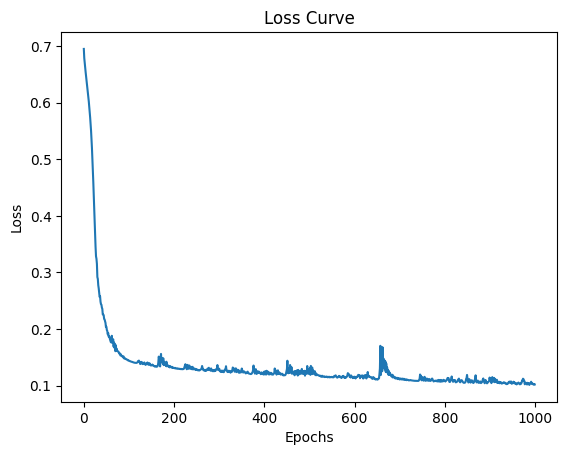

Top-5% True Node Indices: [455, 778, 938, 591, 658, 607, 629, 763, 766, 926, 831, 942, 834, 890, 685, 339, 877, 939, 258, 869, 714, 554, 521, 829, 899, 979, 959, 571, 962, 984, 895, 330, 767, 948, 651, 977, 662, 865, 370, 826, 624, 744, 856, 821, 713, 771, 273, 143, 796, 463]
Top-5% Predicted Node Indices: [607, 984, 554, 455, 763, 899, 778, 939, 938, 591, 834, 948, 962, 829, 662, 258, 929, 831, 890, 959, 339, 856, 877, 869, 926, 629, 685, 865, 821, 785, 516, 960, 592, 919, 694, 942, 273, 352, 714, 790, 147, 735, 571, 137, 757, 843, 958, 463, 914, 738]
Top-5% True Criticality Scores: [0.00018089615332428366, 0.00017895223572850227, 0.00017862040840554982, 0.00016397870786022395, 0.00016072993457783014, 0.000145299025462009, 0.00014128648035693914, 0.0001324074255535379, 0.00013149016012903303, 0.00011245473433518782, 0.00011128453479614109, 0.00011027065920643508, 0.00010617400403134525, 9.61742625804618e-05, 9.592022252036259e-05, 9.507950744591653e-05, 9.442654845770448e-05, 9.219508

In [16]:
# Step 1: Generate a power-law graph
G = generate_power_law(n=1000, m=2)

# Step 2: Compute criticality scores
y_true = compute_criticality_scores(G, compute_effective_resistance)
y_true = torch.tensor(y_true, dtype=torch.float)

# Step 3: Convert to PyG format with node features
data = nx_to_pyg(G, y_true)

# Step 4: Define the model
hidden_dim = 32
model = ILGR(hidden_dim)
print(model)

# Step 5: Train the model
train_model(model, data, y_true, epochs=1000, lr=0.001)

# Step 6: Evaluate the model
model.eval()
y_pred = model(data).detach()  # Ensure no gradients

# Evaluate the top-N% nodes based on their criticality scores (true values)
top_n = int(len(y_true) * 0.05)  # Top 5% nodes
top_n_true_indices = torch.argsort(y_true.squeeze(), descending=True)[:top_n]
top_n_pred_indices = torch.argsort(y_pred.squeeze(), descending=True)[:top_n]

print("Top-5% True Node Indices:", top_n_true_indices.tolist())
print("Top-5% Predicted Node Indices:", top_n_pred_indices.tolist())

# Display top-5% criticality scores for both true and predicted values
print("Top-5% True Criticality Scores:", y_true[top_n_true_indices].tolist())
print("Top-5% Predicted Criticality Scores:", y_pred[top_n_pred_indices].tolist())


accuracy = top_n_accuracy(y_pred, y_true, N=5)  # Top-5% accuracy
print(f"Top-5% Accuracy: {accuracy * 100:.2f}%")